## Molekulardynamik

In diesem Kapitel werden wir Materie und insbedondere Gase einer mikroskopischen Betrachtung unterziehen und daraus makroskopische Eigenschaften wie Druck, Temperatur, innere Energie, Wärmekapazität, Viskosität und Wärmeleitfähigkeit ableiten. Ziel des Kapitels ist es, ein tieferes und anschauliches Verständnis für diese bereits aus der Thermodynamik und Strömungslehre bekannten Größen zu vermitteln.

Der berühmte Physiker Richard Feynman hat die Bedeutung einer atomistischen Betrachtung auf den Punkt gebracht:

> If, in some cataclysm, all of scientific knowledge were to be destroyed, and only one sentence passed on to the next generations of creatures, what statement would contain the most information in the fewest words? I believe it is the *atomic hypothesis* (or the atomic fact, or whatever you wish to call it) that all things are made of *atoms — little particles that move around in perpetual motion, attracting each other when they are a little distance apart, but repelling upon being squeezed into one another.* In that one sentence, you will see, there is an enormous amount of information about the world, if just a little imagination and thinking are applied. ([The Feynman Lecutures on Physics, Band 1, Kapitel 1](http://www.feynmanlectures.caltech.edu))

Wir werden selbst eine Molekulardynamik-Simulation programmieren und verschiedene numerische Experimente durchführen. Da die Simulationen sehr rechanufwändig sind, werden wir nebenbei einige Techniken kennenlernen, um Python-Code effizienter zu machen.

### Das Lennard-Jones-Potential

Um das Verhalten der Atome in der Materie zu simulieren müssen wir die zwischen den Atomen und Molekülen wirkenden Kräfte beschreiben. Wir beschränken uns im Rahmen der Vorlesung dabei auf 1-atomige Gase, wie Helium, Neon, Argon, Krypton oder Xenon, deren Interaktion mit dem sog. Lennard-Jones-Potential sehr gut beschrieben werden kann. Für komplexere Moleküle wird die Vorgehensweise, die wir hier kennenlernen genauso anzuwenden sein, nur müssen dann evtl. andere Potentiale verwendet werden.

Das [Lennard-Jones-Potential](https://de.wikipedia.org/wiki/Lennard-Jones-Potential) resultiert aus der Überlagerung von zwei Kraftfeldern, die zwischen  Atomen wirken:

1.) Eine **starke abstoßende Kraft** mit kurzer Reichweite, die mit dem [Pauli-Prinzip](https://de.wikipedia.org/wiki/Pauli-Prinzip) erklärt werden kann. Dieses besagt, dass zwei Elektronen in einem Atom nicht in allen vier Quantenzahlen übereinstimmen können. Kommen sich nun zwei Atome mit ihren Elektronen sehr nahe, würden zwei Elektronen mit dem gleichen Energieniveau auch in den anderen Quantenzahlen übereinstimmen. Um das Pauli-Prinzip nicht zu verletzen, muss eines der Elektronen seinen Zustand ändern. Da hierfür Energie notwendig ist, muss für eine weitere Annäherung der Atome eine Kraft aufgebracht werden, die proportional zur e-Funktion des Abstands $r$ ist:

$$F_{\text{Pauli}} \propto e^{-r} \qquad \text{oder näherungsweise} \qquad F_{\text{Pauli}} \propto r^{-12}$$

2.) Eine **anziehende Kraft** aufgrund von [van-der-Waals-Kräften](https://de.wikipedia.org/wiki/Van-der-Waals-Kräfte), die mit dem Abstandwie folgt abklingt:

$$F_{vdW} \propto -r^{-6}$$

Das überlagerte Potential ergibt dann:

<div class=highlight>
$$\phi_{LJ}(r) = 4\epsilon\left[\left(\frac{r_0}{r}\right)^{12} - \left(\frac{r_0}{r}\right)^6 \right] \qquad \text{in eV oder J}$$
</div>

mit den Konstanten $\epsilon$ und $r_0$, die von der Art des Atoms abhängen. Der Durchmesser des Atoms ist dabei etwa so groß wie $r_0$. Einige Beispiele für diese Parameter sind in der folgenden Tabelle gezeigt.

| Atom    | $r_0~\text{in Å}$ | $\epsilon~\text{in eV}$ |$m~\text{in u}$ |
| ------- |:-----------------:| :----------------------:|:--------------:|
| Helium  | 2.64              | 0.00094                 | 4              |
| Neon    | 2.74              | 0.00350                 | 20.2           |
| Argon   | 3.35              | 0.01220                 | 39.9           |
| Krypton | 3.58              | 0.01720                 | 83.8           |
| Xenon   | 3.80              | 0.02420                 | 131.3          |

> $1~\text{Å} = 1~\text{Ångström} = 0.1~\text{nm} = 1\cdot 10^{-10} ~\text{m}~$ benannt nach dem schwedischen Astronom [Anders Jonas Ångström](https://de.wikipedia.org/wiki/Anders_Jonas_Ångström).

> $1~\text{eV} = 1~\text{Elektronenvolt} = 1.60218 \cdot 10^{-19}~\text{J}~$ [entspricht der Energie](https://de.wikipedia.org/wiki/Elektronenvolt), die ein Elektron bei der Beschleunigung in einem elektrischen Feld mit 1 V Beschleunigungsspannung hinzugewinnt.

> $1~\text{u} = 1.66054\cdot 10^{-27}~\text{kg}$ entspricht 1/12 der Masse eines Kohlenstoffatoms.

Für das Helium-Atom stellen wir das Potential grafisch dar. Dazu importieren wir zunächst die benötigten Python-Module.

In [149]:
# Benötigte Bibliotheken einbinden und konfigurieren
from matplotlib import animation, rc
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
from numba import jit, int64, float64, void
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rc('font', size=11)

und sind dann bereit, das Potential zu plotten:

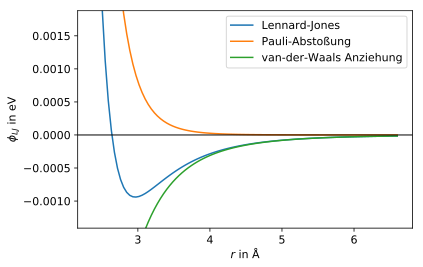

In [150]:
# Funktion, die das Lennard-Jones-Potential berechnet
def lj_potential(r, r0, eps):
    return 4*eps*((r0/r)**12-(r0/r)**6)

# Parameter für das Helium-Atom festlegen
r0  = 2.64        # entspricht etwa dem Atomradius
eps = 0.00094     # Minimum des Lennard-Jones-Potential

r = np.linspace(0.9*r0, 2.5*r0, 100)

# Neuen Plot einrichten
plt.figure(figsize=(6, 4))
plt.ylabel('$\phi_{LJ}$ in eV')
plt.xlabel('$r$ in Å')
plt.ylim(-1.5*eps,2*eps)
plt.plot(r, lj_potential(r,r0,eps), label='Lennard-Jones')
plt.plot(r, 4*eps*((r0/r)**12), label='Pauli-Abstoßung');
plt.plot(r, -4*eps*(r0/r)**6, label='van-der-Waals Anziehung')
plt.legend(loc=1)
plt.axhline(0, color='black', linewidth=1);

Das Minimum des Lennard-Jones-Potentials entspricht gerade dem Wert $-\epsilon$ und tritt bei einem Abstand von $r^* = 2^{1/6}r_0$ auf, der Nulldurchgang der Funktion erfolgt bei $r=r_0$. D.h. bei kleiner kinetischer Energie würden zwei Atome genau im Abstand $r^*$ verharren, in dem die potentielle Energie ein Minimum aufweist.

![](two_atoms.pdf)

Die Kraft zwischen zwei Atomen entspricht gerade der Ortsableitung des Energie-Potentials (Energie ist Kraft $\cdot$ Weg: $E = \int F\cdot \text{d}s$):

$$\big|F\left(\overrightarrow{r}\right)\big| = -\frac{\text{d}\phi(r)}{\text{d}r}=\frac{24\epsilon}{r_0}\left[2\left(\frac{r_0}{r}\right)^{13}-\left(\frac{r_0}{r}\right)^7\right] \qquad \text{in }\frac{\text{J}}{\text{m}}=\text{N}$$

mit $r = |\overrightarrow{r}|$

oder, wenn wir die Information über die Kraftrichtung (auf der Verbindungslinie zwischen den beiden Atomen) beibehalten möchten:


<div class=highlight>
$$\overrightarrow{F}\left(\overrightarrow{r}\right) = \frac{24\epsilon}{r_0^2}\overrightarrow{r}\left[2\left(\frac{r_0}{r}\right)^{14}-\left(\frac{r_0}{r}\right)^8\right]$$
</div>

Bei mehr als zwei Atomen entspricht die resultierende Kraft auf das Atom $i$ durch die anderen $N-1$ Atome gerade:

$$\overrightarrow{F}_i = \sum_{j=1, j\ne i}^N \overrightarrow{F}_{\text{onibyj}}$$

Die Bewegungsgleichung erhalten wir mit dem zweiten Newtonschen Gesetz:

$$\overrightarrow{F}_i = m_i \cdot \overrightarrow{a}_i = m_i\frac{\text{d}\overrightarrow{v}_i}{\text{d}t} =m_i \frac{\text{d}^2\overrightarrow{r}_i}{\text{d}t^2}$$

Im [nächsten Arbeitsblatt](TFD - 2.2 Molekulardynamik - Simulation.ipynb) werden wir die hier hergeleiteten Gleichungen in Python-Code umsetzen und vollständige Molekulardynamiksimulationen durchführen.


---
###### Copyright (c) 2017, Matthias Stripf

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()